# `LOT` on MERFISH

In [35]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## imports

In [36]:
!pip install ott-jax -q

In [37]:
filehandle_hrot = 'drive/Othercomputers/numac/GitHub/HiRef/'
filehandle_nbs = 'drive/MyDrive/DX/OT/_tools/connectome/'

In [38]:
import numpy as np
import pandas as pd
import sklearn.datasets
import sys, time
import torch
import matplotlib.pyplot as plt
import importlib

In [39]:
sys.path.insert(0, filehandle_hrot)
sys.path.insert(0, filehandle_hrot + 'data/')
sys.path.insert(0, filehandle_hrot + 'src/')
import util_merfish as um

In [40]:
import jax
import jax.numpy as jnp
from jax.lib import xla_bridge
from jax import device_put

device = jax.devices("gpu")[0] if jax.devices("gpu") else jax.devices("cpu")[0]
print(f'On device: {device}')
dtype = jnp.float32

On device: cuda:0


In [41]:
from ott import datasets

from ott.geometry import costs, pointcloud
from ott.geometry.epsilon_scheduler import Epsilon
from ott.geometry.geometry import Geometry

from ott.problems.linear import linear_problem, potentials

from ott.solvers.linear import sinkhorn, sinkhorn_lr

In [42]:
'''
import dataclasses
from collections.abc import Iterator, Mapping
from types import MappingProxyType
from typing import Any, Literal, Optional

import optax
''';

In [43]:
import random
from jax import random as jax_random

## set seed

In [44]:
jax_key = um.set_seed(44)

## load merfish spatial data

In [45]:
# contains spatial features
fname1 = filehandle_nbs + '/merfish_data/datasets_mouse_brain_map_BrainReceptorShowcase_Slice2_Replicate3_cell_metadata_S2R3.csv.gz'
fname2 = filehandle_nbs + '/merfish_data/datasets_mouse_brain_map_BrainReceptorShowcase_Slice2_Replicate2_cell_metadata_S2R2.csv.gz'

# contains expression data
X_fname1 = filehandle_nbs + 'merfish_data/'+ 'S2R3_X_BrainReceptorShowcase-Slice2-Replicate3-cell_by_gene_S2R3.csv'
X_fname2 = filehandle_nbs + 'merfish_data/'+ 'S2R2_X_BrainReceptorShowcase-Slice2-Replicate2-cell_by_gene_S2R2.csv'

Number of cells: 85958


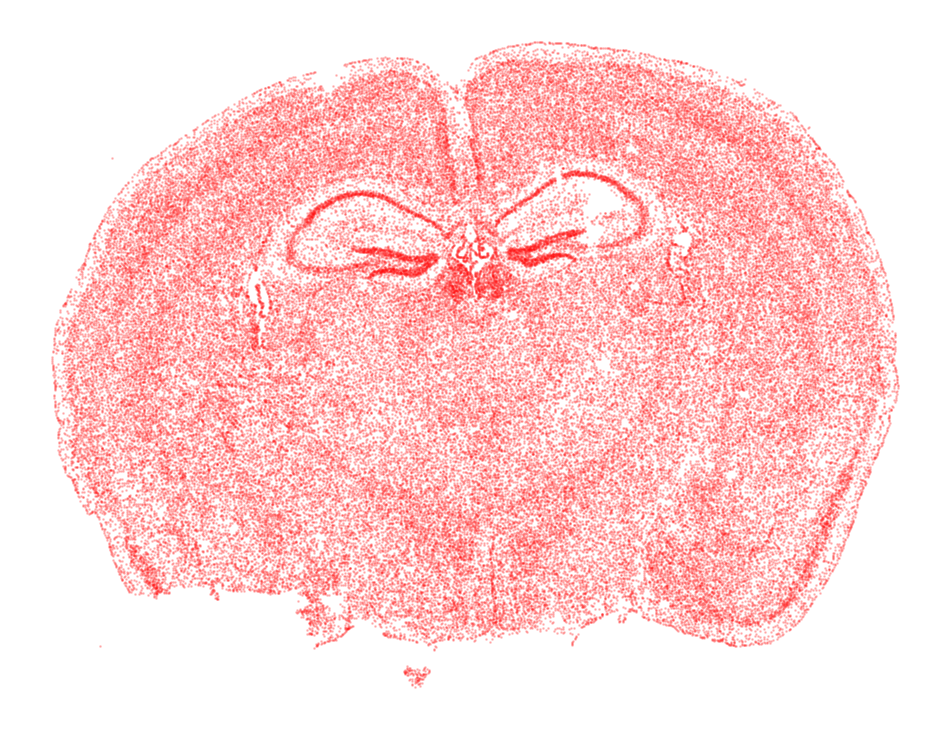

In [46]:
# loading "Slice 2, Replicate 3":
_, _, df1, _, _, xI_c, yI_c, _, _ = um.plot_cell_positions(fname1)

Number of cells: 84172


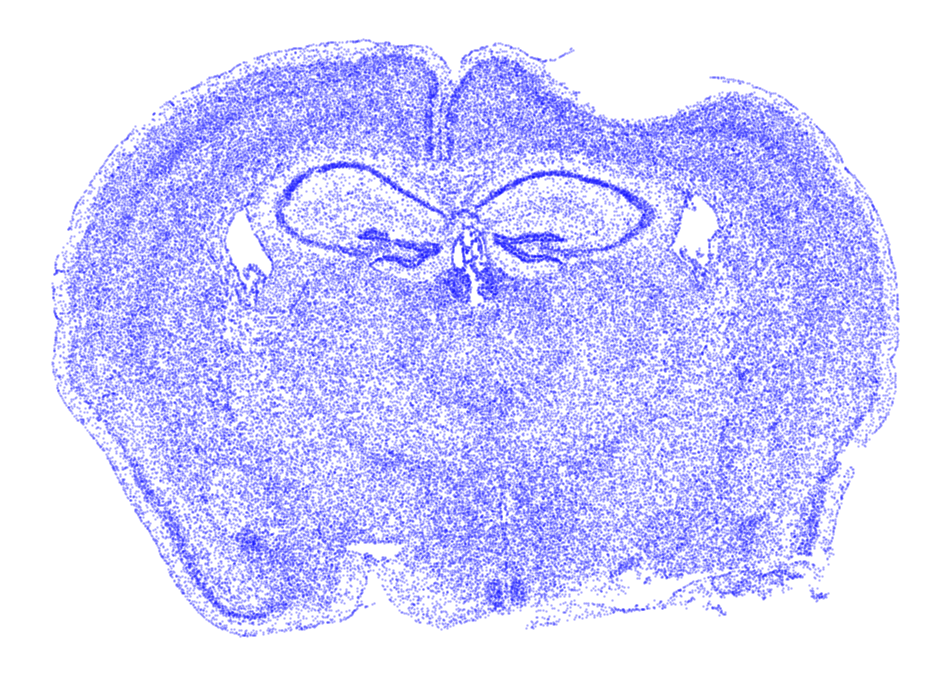

In [47]:
# loading "Slice 2, Replicate 2":
_, _, df2, _, _, _, _, xJ_c_L, yJ_c_L = um.plot_cell_positions(fname2,
                                                               color='blue',
                                                               theta_deg=-45.0)

## centering and rotation of the second slice gives affine registration

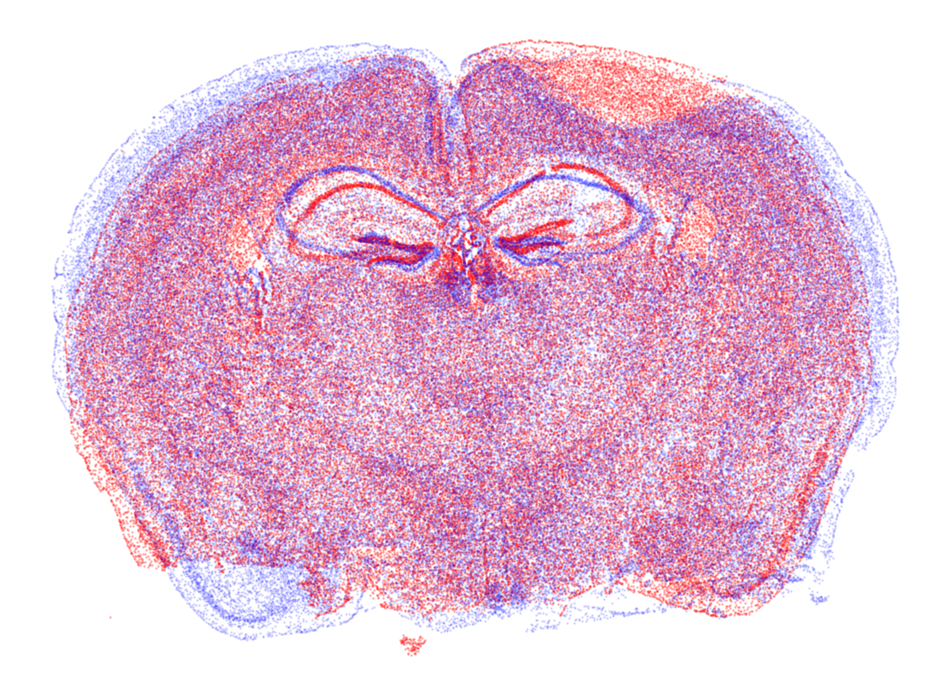

In [48]:
_, _ = um.plot_dual_scatter(xI_c, yI_c, xJ_c_L, yJ_c_L)

## subsample larger slice to make the datasets of equal size

In [49]:
S1_full = np.column_stack((xI_c, yI_c))
S2 = np.column_stack((xJ_c_L, yJ_c_L))

num_to_remove = len(df1) - len(df2)
print(f"Number of cells to remove from first dataset: {num_to_remove}")
indices_to_remove = np.random.choice(S1_full.shape[0], num_to_remove, replace=False)
mask = np.ones(S1_full.shape[0], dtype=bool)
mask[indices_to_remove] = False
S1 = S1_full[mask]
# np.save('S1.npy', S1)
# np.save('S2.npy', S2)

Number of cells to remove from first dataset: 1786


## run `LOT`

In [50]:
%%time
n = 84172

S1_ = jnp.array(S1, dtype=dtype)
S2_ = jnp.array(S2, dtype=dtype)

S1_jax = device_put(S1_, device=device)
S2_jax = device_put(S2_, device=device)

a_ = jnp.ones(n, dtype=dtype)
b_ = jnp.ones(n, dtype=dtype)

a_jax = device_put(a_, device=device)
b_jax = device_put(b_, device=device)

rank = 20

geom = pointcloud.PointCloud(S1_jax, S2_jax, epsilon=0.01)
ot_prob = linear_problem.LinearProblem(geom, a_jax, b_jax)

solver = sinkhorn_lr.LRSinkhorn(rank=rank)
ot_lr = solver(ot_prob)

CPU times: user 33min 39s, sys: 1.4 s, total: 33min 40s
Wall time: 33min 33s


In [51]:
%%time
Q = ot_lr.q
R = ot_lr.r
g = ot_lr.g

Q_np = np.array(Q)
R_np = np.array(R)
g_np = np.array(g)

Q_prime = Q_np / np.sqrt(g_np)
R_prime = R_np / np.sqrt(g_np)

mapping = []
for i in range(n):
    inner_products = R_prime @ Q_prime[i, :]
    j_i = np.argmax(inner_products)
    mapping.append((i, j_i))

# set number of spatial bins along each cardinal direction
num_bins_x = 75
num_bins_y = 75

P_lot = np.array(mapping)
print(f"size of mapping image: {len(set(P_lot[:, 1]))}")


X_df1 = pd.read_csv(X_fname1, sep=',', index_col=0)
X_df1_s = X_df1.iloc[mask]

X_df2 = pd.read_csv(X_fname2, sep=',', index_col=0)

size of mapping image: 6625
CPU times: user 2min 40s, sys: 796 ms, total: 2min 41s
Wall time: 21.4 s


## expression transfer task

### _Grm4_,$\,$ _Slc17a7_, $\,$ _Olig1_, $\,$ _Gad1_, $\,$  _Peg10_

In [52]:
genes = ["Grm4", "Slc17a7", "Olig1", "Gad1", "Peg10"]

for gene in genes:
    um.transfer_and_visualize_gene(source_df=X_df1_s,
                                   target_df=X_df2,
                                   source_coords=S1,
                                   target_coords=S2,
                                   gene_name=gene,
                                   P=P_lot,
                                   num_bins_x=num_bins_x,
                                   num_bins_y=num_bins_y)

Output hidden; open in https://colab.research.google.com to view.

## run `LOT` on _full_ data (no subsampling)

In [53]:
%%time
print(f"size of first dataset: {len(S1_full)}")
print(f"size of second dataset: {len(S2)}")

S1_full_ = jnp.array(S1_full, dtype=dtype)
S2_ = jnp.array(S2, dtype=dtype)

S1_full_jax = device_put(S1_full_, device=device)
S2_jax = device_put(S2_, device=device)

a_ = jnp.ones(len(S1_full), dtype=dtype)
b_ = jnp.ones(len(S2), dtype=dtype)

a_jax = device_put(a_, device=device)
b_jax = device_put(b_, device=device)

rank = 20

geom = pointcloud.PointCloud(S1_full_jax, S2_jax, epsilon=0.01)
ot_prob = linear_problem.LinearProblem(geom, a_jax, b_jax)

solver = sinkhorn_lr.LRSinkhorn(rank=rank)
ot_lr = solver(ot_prob)

size of first dataset: 85958
size of second dataset: 84172
CPU times: user 36min 7s, sys: 1.55 s, total: 36min 8s
Wall time: 36min


In [54]:
%%time
Q = ot_lr.q
R = ot_lr.r
g = ot_lr.g

Q_np = np.array(Q)
R_np = np.array(R)
g_np = np.array(g)

Q_prime = Q_np / np.sqrt(g_np)
R_prime = R_np / np.sqrt(g_np)

mapping = []
for i in range(n):
    inner_products = R_prime @ Q_prime[i, :]
    j_i = np.argmax(inner_products)
    mapping.append((i, j_i))

P_lot_full = np.array(mapping)

print(f"size of mapping image: {len(set(P_lot_full[:, 1]))}")

size of mapping image: 6625
CPU times: user 2min 8s, sys: 28.1 ms, total: 2min 8s
Wall time: 10.9 s


## expression transfer task, without subsampling

In [55]:
genes = ["Grm4", "Slc17a7", "Olig1", "Gad1", "Peg10"]

for gene in genes:
    um.transfer_and_visualize_gene(source_df=X_df1,
                                   target_df=X_df2,
                                   source_coords=S1_full,
                                   target_coords=S2,
                                   gene_name=gene,
                                   P=P_lot_full,
                                   num_bins_x=num_bins_x,
                                   num_bins_y=num_bins_y)

Output hidden; open in https://colab.research.google.com to view.